# 1 day

In [18]:
import numpy as np
import pandas as pd
import netCDF4 as nc4
from netCDF4 import num2date
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset

In [19]:
# Ruta del archivo .nc
ncFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_20_23_filtered_3y.nc'

# Leer los datos del archivo .nc
with nc4.Dataset(ncFileName, mode='r') as ncfid:
    time = ncfid.variables['valid_time'][:]
    lat = ncfid.variables['latitude'][:]
    lon = ncfid.variables['longitude'][:]
    u10 = ncfid.variables['u10'][:]
    v10 = ncfid.variables['v10'][:]

    time_units = ncfid.variables['valid_time'].units
    time_calendar = ncfid.variables['valid_time'].calendar if hasattr(ncfid.variables['valid_time'], 'calendar') else 'standard'
    time_dates = num2date(time, units=time_units, calendar=time_calendar)
    time_dates_dt = [datetime(date.year, date.month, date.day) for date in time_dates]

# Verificar dimensiones
print("Dimensions of the variables:")
print(f"time: {time.shape}, lat: {lat.shape}, lon: {lon.shape}")
print(f"u10: {u10.shape}, v10: {v10.shape}")

# Ruta del archivo CSV con datos de la boya
csvFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'

# Leer datos de la boya
df = pd.read_csv(csvFileName, sep=',', decimal='.', encoding='utf-8')

# columnas de interés
target_cols = ['hmean (m)', 'Tpico_mean (s)', 'Dir_procedencia_mean']
y = df[target_cols].astype(float).values

# DataFrame con fechas del .nc
df_nc = pd.DataFrame({'Fecha': time_dates_dt})
df_nc['Fecha'] = pd.to_datetime(df_nc['Fecha'])
df_nc.set_index('Fecha', inplace=True)

# DataFrame con u10 y v10 indexados por fecha
df_nc_indexed = pd.DataFrame(index=df_nc.index)
df_nc_indexed['u10'] = list(u10[:, 93, 88])  # píxel específico
df_nc_indexed['v10'] = list(v10[:, 93, 88])

df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
df_merged = pd.merge(df, df_nc_indexed, left_on='Fecha', right_index=True)
df_merged.sort_values('Fecha', inplace=True)
df_merged.reset_index(drop=True, inplace=True)

X = np.array([np.sqrt(u**2 + v**2) for u, v in zip(df_merged['u10'], df_merged['v10'])])
y = df_merged[target_cols].values

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Dimensions of the variables:
time: (6879,), lat: (128,), lon: (128,)
u10: (6879, 128, 128), v10: (6879, 128, 128)
Shape of X: (6879,)
Shape of y: (6879, 3)


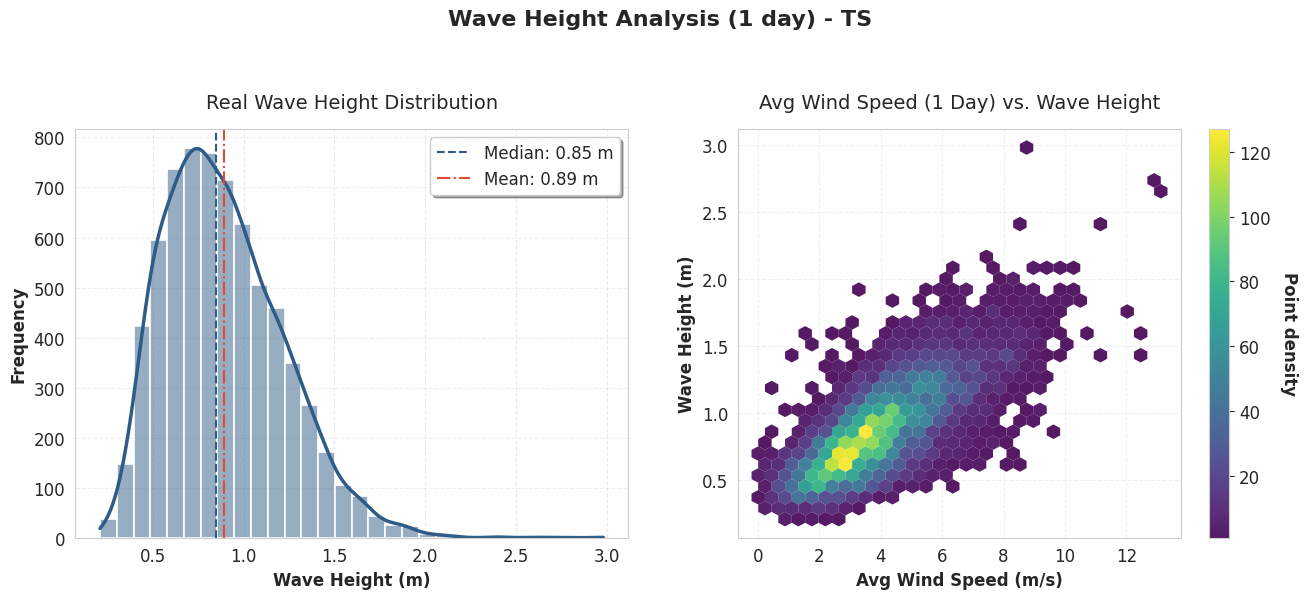

In [20]:
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

fig = plt.figure(figsize=(14, 6))
fig.suptitle('Wave Height Analysis (1 day) - TS', 
             fontsize=16, fontweight='bold', y=1.05)

# Distribución de altura
ax1 = plt.subplot(1, 2, 1)

hist = sns.histplot(
    x=y[:, 0],  # Altura media (hmean)
    bins=30,
    kde=True,
    color='#2e5c87',  # Azul
    edgecolor='white',
    linewidth=1.2,
    line_kws={
        'color': '#e34a33',  # Rojo anaranjado para KDE
        'linewidth': 2.5,
        'linestyle': '-'
    }
)

median = np.median(y[:, 0])
mean = np.mean(y[:, 0])
ax1.axvline(median, color='#2e5c87', linestyle='--', linewidth=1.5, 
            label=f'Median: {median:.2f} m')
ax1.axvline(mean, color='#e34a33', linestyle='-.', linewidth=1.5,
            label=f'Mean: {mean:.2f} m')

ax1.set_title("Real Wave Height Distribution", pad=15)
ax1.set_xlabel("Wave Height (m)", fontweight='semibold')
ax1.set_ylabel("Frequency", fontweight='semibold')
ax1.legend(frameon=True, shadow=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Viento vs Altura
ax2 = plt.subplot(1, 2, 2)

hexbin = ax2.hexbin(
    X,
    y[:, 0],
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.9
)

cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')
ax2.set_title("Avg Wind Speed (1 Day) vs. Wave Height", pad=15)
ax2.set_xlabel("Avg Wind Speed (m/s)", fontweight='semibold')
ax2.set_ylabel("Wave Height (m)", fontweight='semibold')
ax2.grid(alpha=0.3)

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)

plt.savefig(
    'height_relation_1day.png', 
    dpi=300, 
    bbox_inches='tight',
    facecolor='white'
)

plt.show()


# 6 days

In [21]:
# Ruta al archivo NetCDF con 6 días
nc_path = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_2000_2023_128x128_filtered_tfs_5days.nc'

with Dataset(nc_path, mode='r') as ncfile:
    u_wind = []
    v_wind = []
    for day in range(6):  # u0 a u5, v0 a v5
        u = ncfile.variables[f'u{day}'][:, 93, 88]
        v = ncfile.variables[f'v{day}'][:, 93, 88]
        u_wind.append(u)
        v_wind.append(v)

    # shape (n_samples, 6)
    u_stack = np.stack(u_wind, axis=1)
    v_stack = np.stack(v_wind, axis=1)

    # Velocidad promedio del viento
    wind_speed_avg = np.sqrt(u_stack**2 + v_stack**2).mean(axis=1)

# CSV
csv_path = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'
df_wave = pd.read_csv(csv_path, sep=',', decimal='.', encoding='utf-8')

df_wave['Fecha'] = pd.to_datetime(df_wave['Fecha'], dayfirst=True)
heights = df_wave['hmean (m)'].astype(float).values

# Alineamos longitudes
min_len = min(len(wind_speed_avg), len(heights))
heights = heights[:min_len]
wind_speed_avg = wind_speed_avg[:min_len]


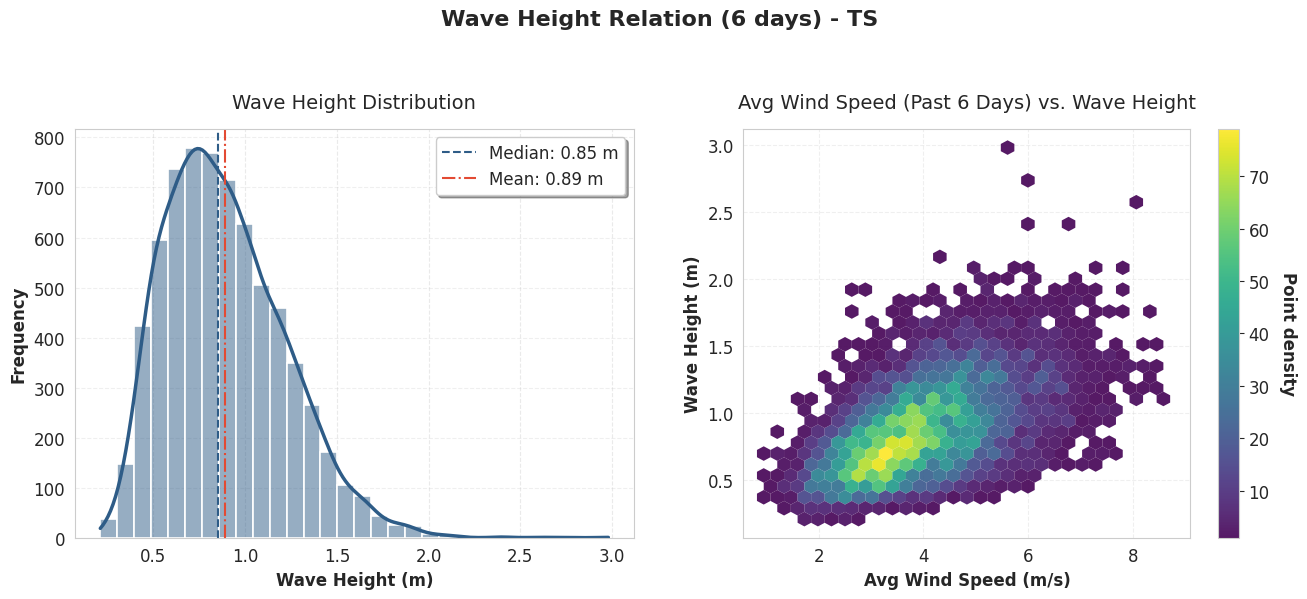

In [22]:
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

fig = plt.figure(figsize=(14, 6))
fig.suptitle('Wave Height Relation (6 days) - TS',
             fontsize=16, fontweight='bold', y=1.05)

# Histograma de altura
ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    x=heights,
    bins=30,
    kde=True,
    color='#2e5c87',
    edgecolor='white',
    linewidth=1.2,
    line_kws={'color': '#e34a33', 'linewidth': 2.5}
)
median = np.median(heights)
mean = np.mean(heights)
ax1.axvline(median, color='#2e5c87', linestyle='--', linewidth=1.5,
            label=f'Median: {median:.2f} m')
ax1.axvline(mean, color='#e34a33', linestyle='-.', linewidth=1.5,
            label=f'Mean: {mean:.2f} m')
ax1.set_title("Wave Height Distribution", pad=15)
ax1.set_xlabel("Wave Height (m)", fontweight='semibold')
ax1.set_ylabel("Frequency", fontweight='semibold')
ax1.legend(frameon=True, shadow=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Viento promedio vs altura
ax2 = plt.subplot(1, 2, 2)
hexbin = ax2.hexbin(
    wind_speed_avg,
    heights,
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.9
)
cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')
ax2.set_title("Avg Wind Speed (Past 6 Days) vs. Wave Height", pad=15)
ax2.set_xlabel("Avg Wind Speed (m/s)", fontweight='semibold')
ax2.set_ylabel("Wave Height (m)", fontweight='semibold')
ax2.grid(alpha=0.3)

# Layout final
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)
plt.savefig('height_relation_6days.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


# Valor Real csv vs. Valor Modelo nCDF

In [23]:
# Rutas de los archivos
ncFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Datos_Albano_Modelo/wave_wind_2000_2023_128x128_filtered_tfs_5days.nc'
csvFileName = '/disk/barbusano/barbusano1/Projects/Waves/IAwave/Tania_TFG/Datos/Boya Tenerife Sur/DailyWaveStats_4p_20_23_TS.csv'

# NC
with nc4.Dataset(ncFileName, mode='r') as ncfid:
    time = ncfid.variables['valid_time'][:]
    lat = ncfid.variables['latitude'][:]
    lon = ncfid.variables['longitude'][:]
    swh0 = ncfid.variables['swh0'][:]  # modelo: significant wave height, día 0 (día de la medida)

    # Convertir tiempo a fechas
    time_units = ncfid.variables['valid_time'].units
    time_calendar = ncfid.variables['valid_time'].calendar if hasattr(ncfid.variables['valid_time'], 'calendar') else 'standard'
    time_dates = num2date(time, units=time_units, calendar=time_calendar)
    time_dates_dt = [datetime(d.year, d.month, d.day) for d in time_dates]

# posición de la boya (93, 88)
df_model = pd.DataFrame({
    'Fecha': pd.to_datetime(time_dates_dt),
    'swh_model': swh0[:, 93, 88]
})
df_model.set_index('Fecha', inplace=True)

# CSV
df_boya = pd.read_csv(csvFileName, sep=',', decimal='.', encoding='utf-8')
df_boya['Fecha'] = pd.to_datetime(df_boya['Fecha'], dayfirst=True)


df_boya_height = df_boya[['Fecha', 'hmean (m)']]
df_boya_height.rename(columns={'hmean (m)': 'swh_real'}, inplace=True)
df_boya_height.set_index('Fecha', inplace=True)

df_comp = pd.merge(df_boya_height, df_model, left_index=True, right_index=True)

# Verificación
print(df_comp.head())
print(f"Shape: {df_comp.shape}")

            swh_real  swh_model
Fecha                          
2003-05-06     1.460   1.968896
2003-05-07     1.555   2.152539
2003-05-08     1.445   1.918756
2003-05-09     1.260   1.487693
2003-05-10     1.110   1.446293
Shape: (6879, 2)


/tmp/ipykernel_1530286/2033627316.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boya_height.rename(columns={'hmean (m)': 'swh_real'}, inplace=True)


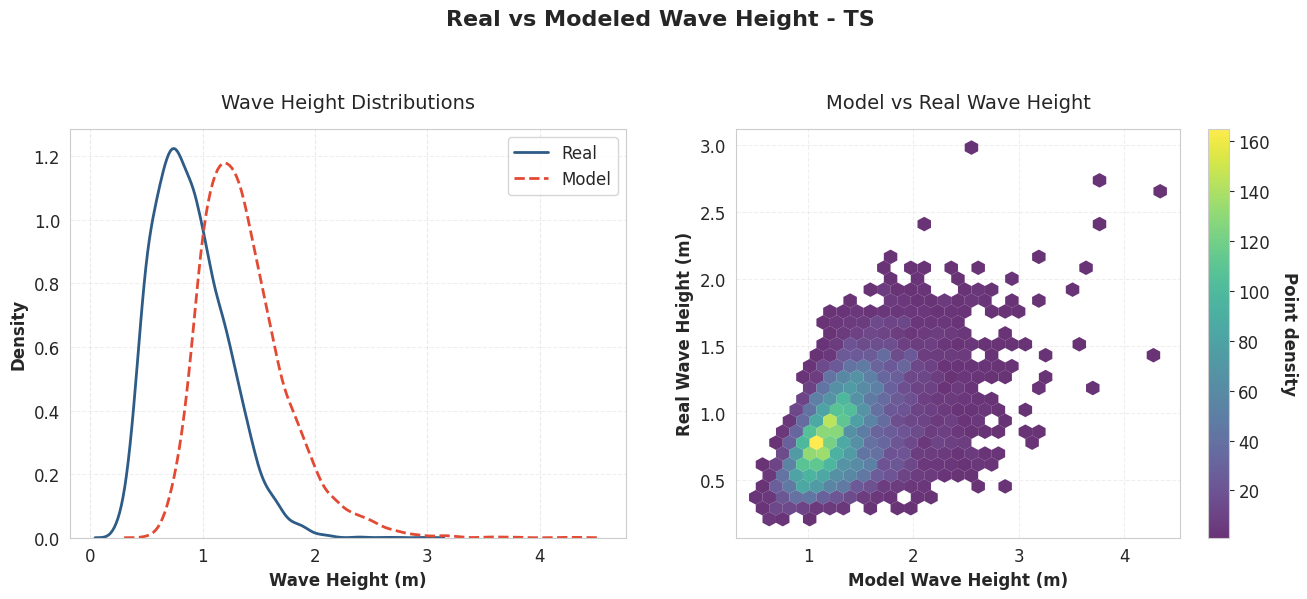

In [24]:
# Configurar estilo visual
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelweight': 'bold',
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'figure.facecolor': 'white'
})

fig = plt.figure(figsize=(14, 6))
fig.suptitle('Real vs Modeled Wave Height - TS', 
             fontsize=16, fontweight='bold', y=1.05)

# Histogramas comparativos
ax1 = plt.subplot(1, 2, 1)

sns.kdeplot(df_comp['swh_real'], label='Real', color='#2e5c87', linewidth=2)
sns.kdeplot(df_comp['swh_model'], label='Model', color='#e34a33', linewidth=2, linestyle='--')

ax1.set_title("Wave Height Distributions", pad=15)
ax1.set_xlabel("Wave Height (m)", fontweight='semibold')
ax1.set_ylabel("Density", fontweight='semibold')
ax1.legend(frameon=True, loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Dispersión modelo vs real
ax2 = plt.subplot(1, 2, 2)

hexbin = ax2.hexbin(
    df_comp['swh_model'],
    df_comp['swh_real'],
    gridsize=30,
    cmap='viridis',
    mincnt=1,
    edgecolors='none',
    alpha=0.8
)

cbar = plt.colorbar(hexbin, ax=ax2)
cbar.set_label('Point density', rotation=270, labelpad=20, fontweight='semibold')

ax2.set_title("Model vs Real Wave Height", pad=15)
ax2.set_xlabel("Model Wave Height (m)", fontweight='semibold')
ax2.set_ylabel("Real Wave Height (m)", fontweight='semibold')
ax2.grid(alpha=0.3)

# Ajustes finales
plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.85)

# Guardar figura
plt.savefig('real_vs_model_wave_height.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
